In [2]:
import PyKDL as kdl
import kdl_parser_py.urdf
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tf
import numpy as np
import copy
from itertools import repeat

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

util_path = os.path.abspath("../utils/")
sys.path.append(util_path)
import transformation as trans
import projections as proj
import robot_visualize as rbvis

np.set_printoptions(suppress=True)


act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from utils import EpisodicDataset
from utils import find_all_hdf5, flatten_list, get_norm_stats
from utils import load_data # data functions

In [3]:
act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from policy import EPACTPolicy, ACTPolicy
from brl_constants import TASK_CONFIGS

ckpt_path = "/mnt/data1/act/train_act_scara_3cam/3cam_epact_v5/"

config_path = ckpt_path + "config.pkl"
# step = 500000
# policy_model_path = ckpt_path + "policy_step_%i_seed_0.ckpt"%step
policy_model_path = ckpt_path + "policy_step_30000_seed_0.ckpt"

stats_path = ckpt_path + "dataset_stats.pkl"

with open(config_path, "rb") as f:
    policy_config = pickle.load(f)['policy_config']
    print(policy_config)

policy = EPACTPolicy(policy_config)
loading_status = policy.deserialize(torch.load(policy_model_path))

with open(stats_path, "rb") as f:
    stats = pickle.load(f)

pre_process_qpos = (
    lambda s_qpos: torch.from_numpy((s_qpos - stats["qpos_mean"]) / stats["qpos_std"])
    .float()
    .cuda()
    .unsqueeze(0)
)
post_process_action = lambda a: a * stats["action_std"] + stats["action_mean"]

print("loading EPACTPolicy policy success")

ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /home/zfei/code/robomimic/robomimic/scripts/setup_macros.py
)


/home/zfei/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
urdf_path =  "/home/zfei/code/act-plus-plus/urdf/hitbot_model.urdf"
print("URDF Path: ", urdf_path)
(ok, tree)  = kdl_parser_py.urdf.treeFromFile(urdf_path)
print("kdl_parse urdf ok?: ", ok)
chain = tree.getChain("world", "camera_link")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)


URDF Path:  /home/zfei/code/act-plus-plus/urdf/hitbot_model.urdf
kdl_parse urdf ok?:  True


In [9]:
camera_names = policy_config["camera_names"]
print(camera_names)

['wrist', 'wrist_down', 'top']


In [10]:
def pre_proccess_img(img):
    img_torch = torch.from_numpy(img).unsqueeze(0)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

def pre_process_multi_img(curr_images):
    # a list of images [w, h, 3]
    curr_image = np.stack(curr_images, axis=0)
    img_torch = torch.from_numpy(curr_image)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

def post_process_all_actions(all_actions):
    # post process all actions
    joint_states_traj = []
    actual_actions = []
    for i, raw_action in enumerate(all_actions):
        actual_action = post_process_action(raw_action)
        actual_actions.append(actual_action)
    actual_actions = np.asarray(actual_actions)
    # print(actual_actions)
    return actual_actions

def get_camera_in_world_and_init(ee_poses_raw, init_states=None):
    transformation_matrix, rot_mat_ext, translation_mat= trans.kdl_frame_to_mat(ee_poses_raw[0])
    ee_in_world_init = transformation_matrix
    world_T_init = np.linalg.inv(ee_in_world_init)

    ee_in_world_all = []
    ee_in_init_all = []
    ee_in_init_all_pos = []
    ee_in_world_all_pos = []
    for ee_pose in ee_poses_raw:
        ee_in_world_all_pos.append([ee_pose.p[0], ee_pose.p[1], ee_pose.p[2], 1])
        ee_in_world, _, _= trans.kdl_frame_to_mat(ee_pose)
        ee_in_world_all.append(ee_in_world)
        ee_in_init = world_T_init.dot(ee_in_world)
        ee_in_init_all.append(ee_in_init)
        ee_in_init_all_pos.append(ee_in_init[:3, 3])
        
        # print("ee rpy: ", tf.euler_from_matrix(ee_in_init, 'rxyz'))

    ee_in_init_all_pos = np.asarray(ee_in_init_all_pos)
    ee_in_world_all_pos = np.asarray(ee_in_world_all_pos)
    ee_in_init_all = np.asarray(ee_in_init_all)
    return  ee_in_init_all_pos, ee_in_world_all_pos, ee_in_init_all

def repeater(data_loader):
    epoch = 0
    for loader in repeat(data_loader):
        for data in loader:
            yield data
        print(f'Epoch {epoch} done')
        epoch += 1

In [11]:
(ok, tree)  = kdl_parser_py.urdf.treeFromFile("../hitbot_model.urdf")
print("ok: ", ok)
chain = tree.getChain("world", "camera_link")
fk_solver = kdl.ChainFkSolverPos_recursive(chain)
rgb_p = np.asarray([[429.76348876953125, 0.0, 321.4649658203125, 
                     0.0, 0.0, 429.129150390625, 242.32749938964844, 
                     0.0, 0.0, 0.0, 1.0, 0.0]]).reshape([3, 4])
rgb_p

ok:  True


array([[429.76348877,   0.        , 321.46496582,   0.        ],
       [  0.        , 429.12915039, 242.32749939,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

In [12]:
dataset_path_list = find_all_hdf5("/mnt/data1/act/train_act_scara_3cam/data1/", skip_mirrored_data=False)
norm_stats, all_episode_len = get_norm_stats(dataset_path_list)

camera_names = ['wrist', 'wrist_down', 'top']
train_episode_ids = [0, 1]
train_episode_len = [all_episode_len[i] for i in train_episode_ids]

val_episode_ids = [0, 1]
val_episode_len = [all_episode_len[i] for i in val_episode_ids]

chunk_size = 64

dataset_dir = "/mnt/data1/act/train_act_scara_3cam/data1/"

TASK_CONFIGS = {
        'epact':{
        'dataset_dir': dataset_dir + '/train_act_scara_3cam',
        'num_episodes': 100,
        'episode_len': 300,
        'camera_names': ['wrist', 'wrist_down', 'top']
    }
}
task_config = TASK_CONFIGS['epact']
name_filter = task_config.get('name_filter', lambda n: True)
batch_size_train = 1
batch_size_val = 1

chunk_size = 100
skip_mirrored_data = False
load_pretrain = False
train_ratio = 0.99
policy_class = "EPACT"
train_dataloader,val_dataloader, stats, _ = load_data(dataset_dir, 
                                                       name_filter, 
                                                       camera_names, 
                                                       batch_size_train, 
                                                       batch_size_val, 
                                                       chunk_size,
                                                       skip_mirrored_data,
                                                       load_pretrain,
                                                       policy_class,
                                                       stats_dir_l=None,
                                                       sample_weights=None,
                                                       train_ratio=train_ratio)
train_dataloader = repeater(train_dataloader)


Found 51 hdf5 files
Found 51 hdf5 files


Data from: ['/mnt/data1/act/train_act_scara_3cam/data1/']
- Train on [50] episodes
- Test on [1] episodes


Found 51 hdf5 files
Norm stats from: ['/mnt/data1/act/train_act_scara_3cam/data1/']
train_episode_len: [110, 116, 118, 154, 118, 175, 121, 120, 90, 128, 104, 106, 121, 161, 139, 101, 135, 153, 104, 128, 123, 110, 168, 137, 103, 124, 144, 127, 136, 177, 154, 108, 125, 98, 117, 124, 117, 111, 114, 140, 129, 135, 107, 168, 132, 118, 151, 136, 135, 116], val_episode_len: [165], train_episode_ids: [26 39 11 40 13 25  2 36 21 16 47 22 46 37 38 27 31 41  3  4 43 24 34  0
 30 28 45  1 14 44 10  5 18  7 35 23 48 12 20 50  9  8  6 19 15 33 32 17
 29 42], val_episode_ids: [49]
val data:  /mnt/data1/act/train_act_scara_3cam/data1/episode_25.hdf5
URDF Path:  /home/zfei/code/act-plus-plus/urdf/hitbot_model.urdf
kdl_parse urdf ok?:  True
augment_images:  False
Initializing transformations
URDF Path:  /home/zfei/code/act-plus-plus/urdf/hitbot_model.urdf


In [19]:
data = next(train_dataloader)
image_data_cpu, qpos_data_cpu, action_data_cpu, is_pad, end_pose_data = data
image_data, qpos_data, action_data, is_pad, end_pose_data = image_data_cpu.cuda(), qpos_data_cpu.cuda(), action_data_cpu.cuda(), is_pad.cuda(), end_pose_data.cuda()

print("image_data", image_data.shape)
print("qpos_data", qpos_data.shape)
print("action_data", action_data.shape)
print("is_pad", is_pad.shape)
print("end_pose_data", end_pose_data.shape)


image_data torch.Size([1, 3, 3, 480, 640])
qpos_data torch.Size([1, 4])
action_data torch.Size([1, 100, 5])
is_pad torch.Size([1, 100])
end_pose_data torch.Size([1, 100, 6])


(100, 5)
(480, 640, 3)


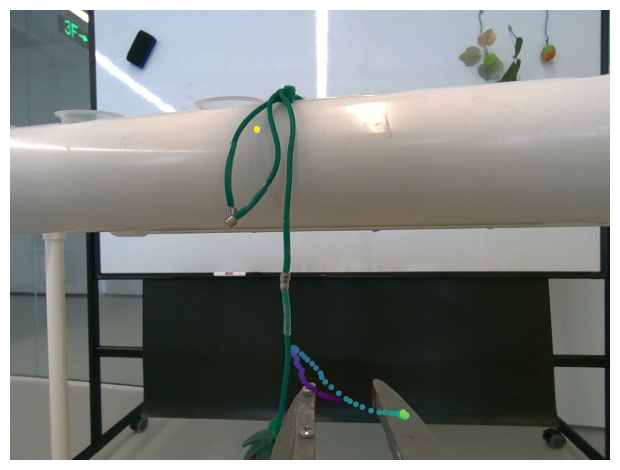

In [20]:
all_actions_gt = action_data_cpu.squeeze().numpy()
image = image_data_cpu.squeeze().numpy()[0].transpose(1, 2, 0)
qpos = qpos_data_cpu.squeeze().numpy()
print(all_actions_gt.shape)
print(image.shape)
actual_actions = post_process_all_actions(all_actions_gt)
all_actions = np.vstack([np.append(qpos, 0), actual_actions])

vis_actions = actual_actions 
rbvis.paint_action_in_image(image, vis_actions, rgb_p, fk_solver, chain, save_path=None)

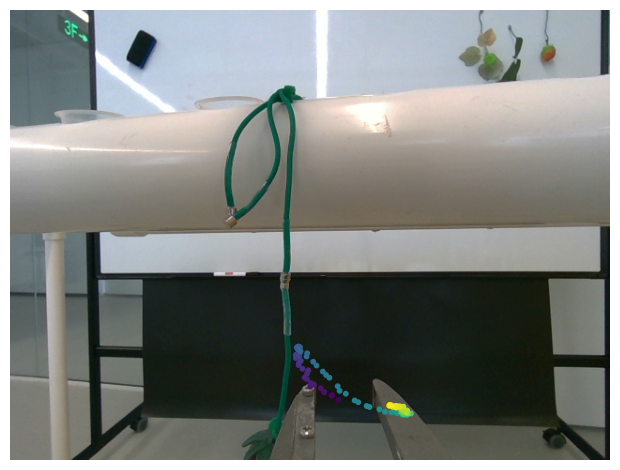

In [21]:
all_actions_hat, end_poses = policy(qpos_data, image_data)
all_actions_hat = all_actions_hat.squeeze(0).cpu().detach().numpy()
actual_actions = post_process_all_actions(all_actions_hat)
all_actions = np.vstack([np.append(qpos, 0), actual_actions])

vis_actions = actual_actions # Predicted action

rbvis.paint_action_in_image(image, vis_actions, rgb_p, fk_solver, chain, save_path=None)

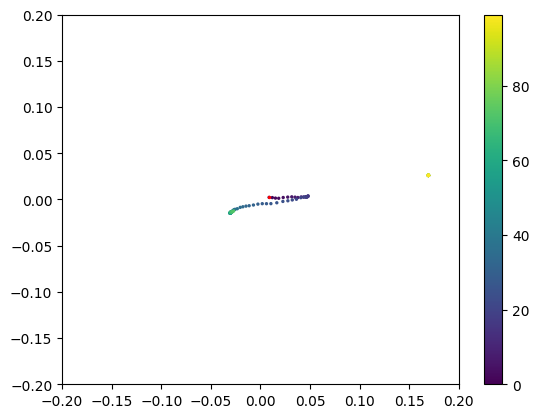

In [64]:
end_pose_gt = end_pose_data.squeeze(0).cpu().detach().numpy()
plt.scatter(end_pose_gt[:, 0], end_pose_gt[:, 1], c=range(len(end_pose_gt)), s=2)

plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
plt.colorbar()
plt.scatter(end_pose_gt[0, 0], end_pose_gt[0, 1], c='r', s=2)


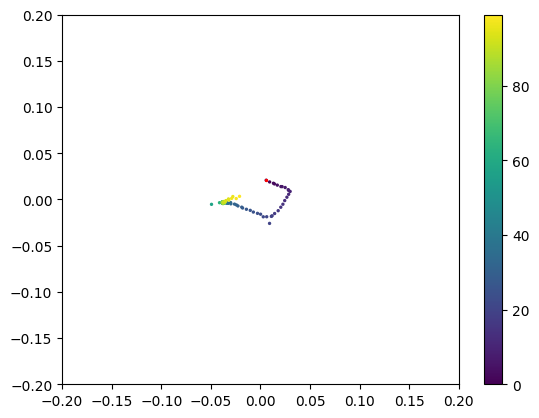

In [65]:
end_poses_hat = end_poses.squeeze(0).cpu().detach().numpy()
plt.scatter(end_poses_hat[:, 0], end_poses_hat[:, 1], c=range(len(end_poses_hat)), s=2)

plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])
plt.colorbar()
plt.scatter(end_poses_hat[0, 0], end_poses_hat[0, 1], c='r', s=2)
